In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [ ]:
df = pd.read_csv('sample_data/dataset.csv')

print(df.shape)
display(df.head())

(114000, 21)


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


Очистка данных

In [ ]:
df.drop(columns=['Unnamed: 0'], inplace=True)
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

,0
artists,1
album_name,1
track_name,1


In [ ]:
threshold = 5

valid_columns = df.columns[((df.isnull().sum() / len(df)) * 100) < threshold]

df = df.dropna(subset=valid_columns)

In [ ]:
duplicate_rows = df.duplicated().sum()
df.drop_duplicates(inplace=True)

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113549 entries, 0 to 113548
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          113549 non-null  object 
 1   artists           113549 non-null  object 
 2   album_name        113549 non-null  object 
 3   track_name        113549 non-null  object 
 4   popularity        113549 non-null  int64  
 5   duration_ms       113549 non-null  int64  
 6   explicit          113549 non-null  bool   
 7   danceability      113549 non-null  float64
 8   energy            113549 non-null  float64
 9   key               113549 non-null  int64  
 10  loudness          113549 non-null  float64
 11  mode              113549 non-null  int64  
 12  speechiness       113549 non-null  float64
 13  acousticness      113549 non-null  float64
 14  instrumentalness  113549 non-null  float64
 15  liveness          113549 non-null  float64
 16  valence           11

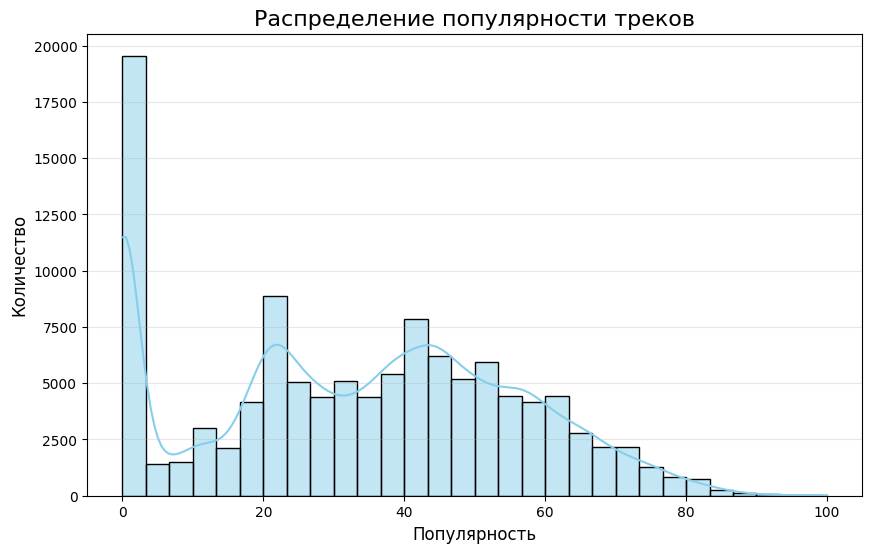

In [ ]:
# Распределение целевой переменной
plt.figure(figsize=(10, 6))
sns.histplot(df['popularity'], bins=30, kde=True, color='skyblue')
plt.title('Распределение популярности треков', fontsize=16)
plt.xlabel('Популярность', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()

<ipython-input-106-52d85986b8c2>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_artists.values, y=top_artists.index, palette='viridis')


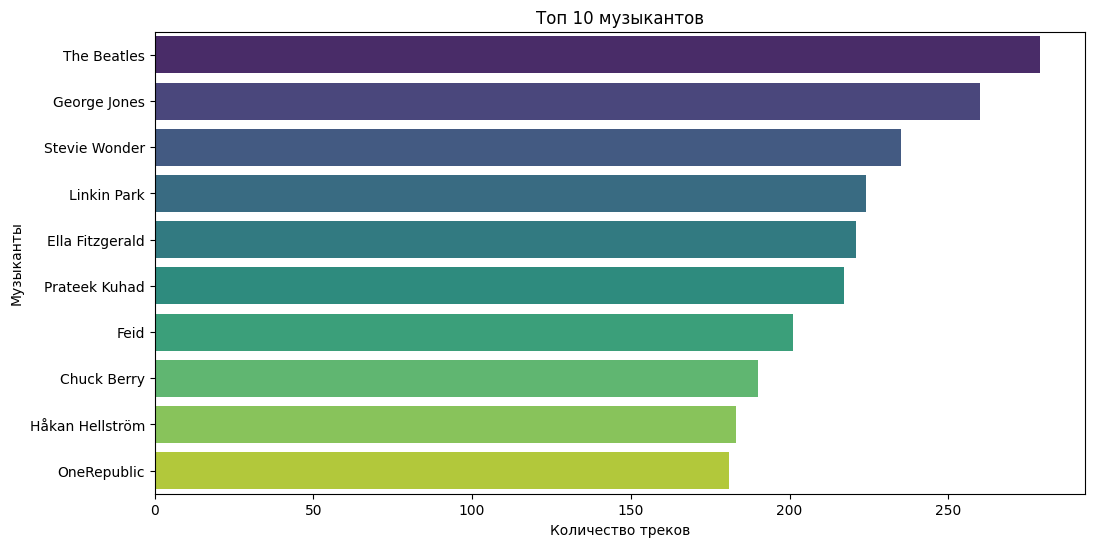

In [ ]:
top_artists = df['artists'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_artists.values, y=top_artists.index, palette='viridis')
plt.title('Топ 10 музыкантов')
plt.xlabel('Количество треков')
plt.ylabel('Музыканты')
plt.show()

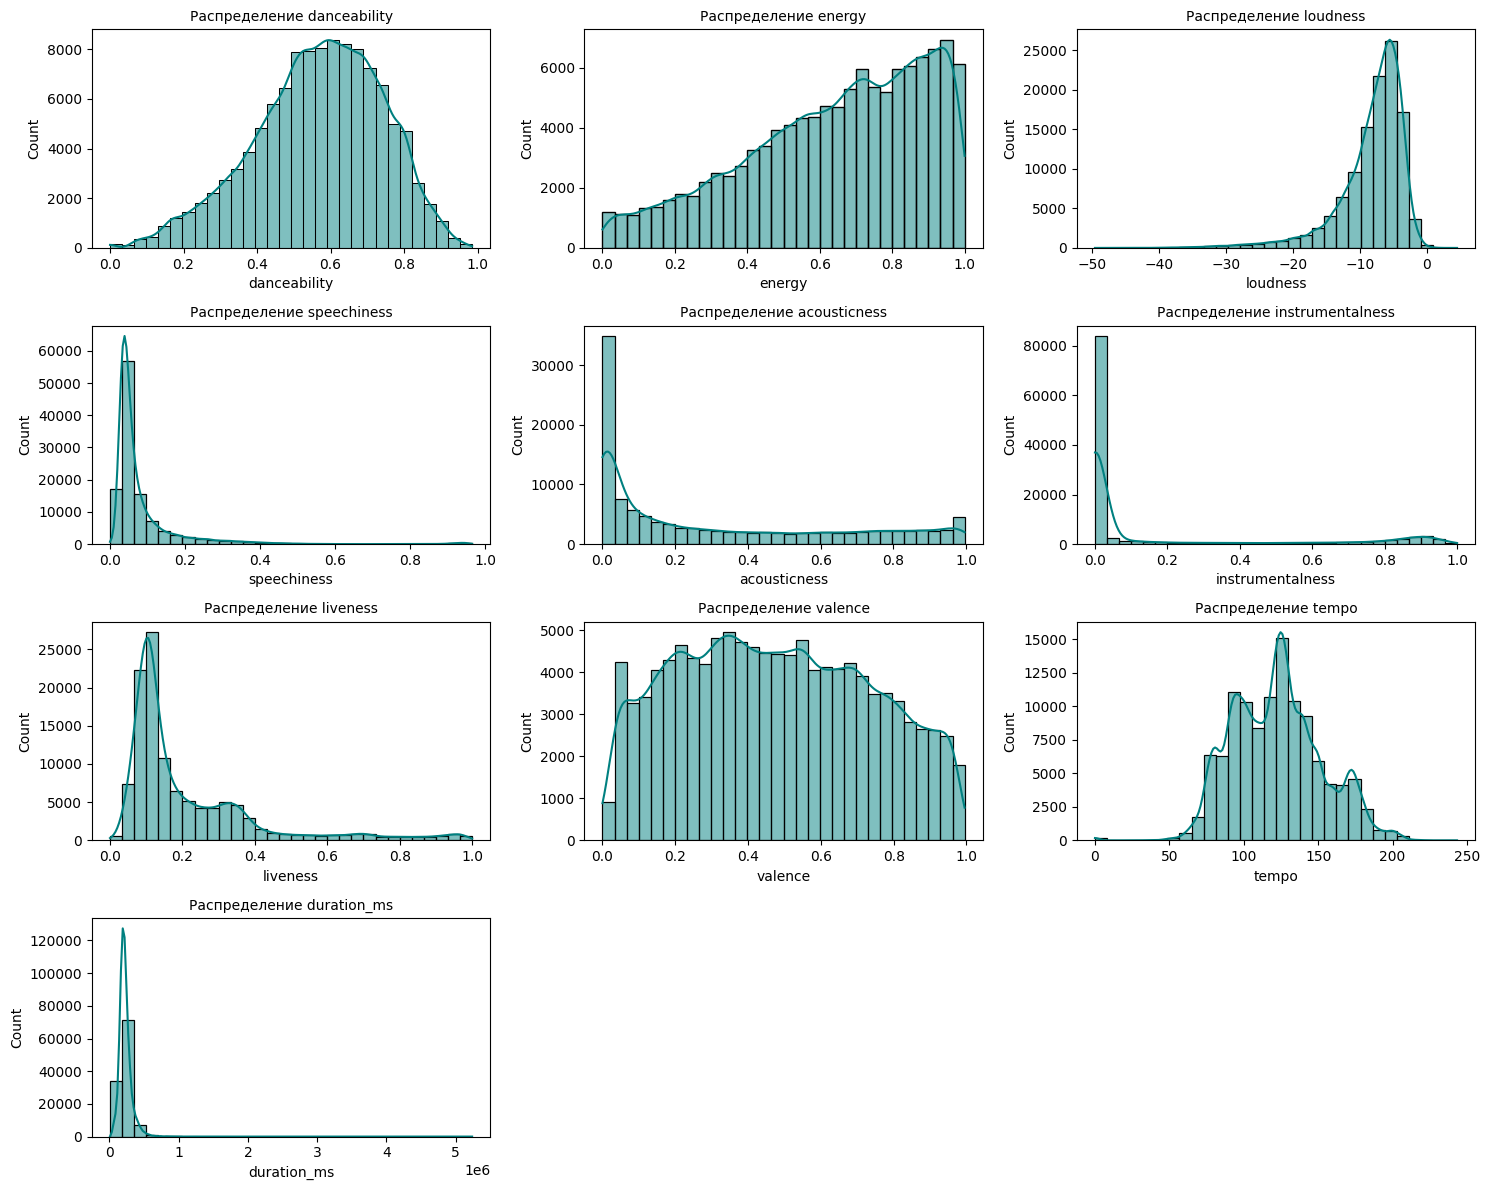

In [ ]:
# Распределение числовых признаков
numeric_features = ['danceability', 'energy', 'loudness', 'speechiness',
                   'acousticness', 'instrumentalness', 'liveness',
                   'valence', 'tempo', 'duration_ms']

plt.figure(figsize=(15, 12))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(4, 3, i)
    sns.histplot(df[feature], bins=30, kde=True, color='teal')
    plt.title(f'Распределение {feature}', fontsize=10)
    plt.tight_layout()
plt.show()

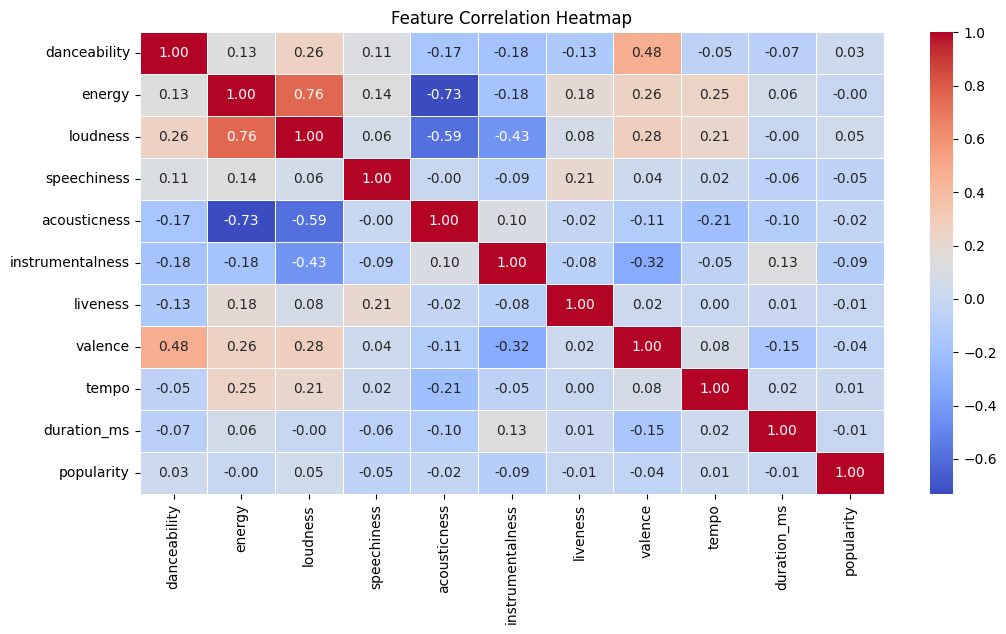

In [ ]:
# Корреляция с целевой переменной
correlation = df[numeric_features + ['popularity']].corr()

plt.figure(figsize=(12, 6))
sns.heatmap(correlation, annot=True, fmt='.2f', linewidths=0.5, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

<ipython-input-109-b68c4587f625>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette='viridis')


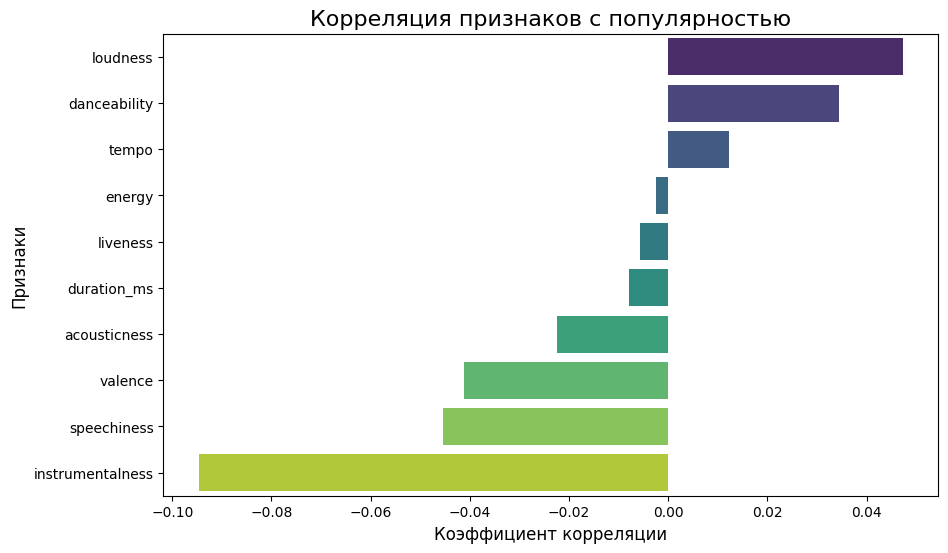

In [ ]:
# Наиболее коррелирующие признаки
corr_with_target = correlation['popularity'].sort_values(ascending=False)[1:]
plt.figure(figsize=(10, 6))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette='viridis')
plt.title('Корреляция признаков с популярностью', fontsize=16)
plt.xlabel('Коэффициент корреляции', fontsize=12)
plt.ylabel('Признаки', fontsize=12)
plt.show()

Feature Engineering

In [ ]:
df = df.drop(columns=['track_id', 'artists', 'album_name', 'track_name'])

In [ ]:
df['duration_min'] = df['duration_ms']
df['energy_danceability_ratio'] = df['energy'] / (df['danceability'])

scaler = StandardScaler()
df['loudness_scaled'] = scaler.fit_transform(df[['loudness']])

df['tempo_category'] = pd.cut(df['tempo'], bins=[0, 90, 140, df['tempo'].max()], labels=['slow', 'medium', 'fast'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113549 entries, 0 to 113548
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   popularity                 113549 non-null  int64   
 1   duration_ms                113549 non-null  int64   
 2   explicit                   113549 non-null  bool    
 3   danceability               113549 non-null  float64 
 4   energy                     113549 non-null  float64 
 5   key                        113549 non-null  int64   
 6   loudness                   113549 non-null  float64 
 7   mode                       113549 non-null  int64   
 8   speechiness                113549 non-null  float64 
 9   acousticness               113549 non-null  float64 
 10  instrumentalness           113549 non-null  float64 
 11  liveness                   113549 non-null  float64 
 12  valence                    113549 non-null  float64 
 13  tempo         

In [ ]:
df['explicit'] = df['explicit'].astype(int)
df['tempo_category'] = df['tempo_category'].astype(str)

In [ ]:
df = pd.get_dummies(df, columns=['tempo_category'], drop_first=True)

In [ ]:
track_genre_counts = df['track_genre'].value_counts(normalize=True)
df['track_genre_encoded'] = df['track_genre'].map(track_genre_counts)

In [ ]:
df = df.drop(columns=['duration_ms', 'energy', 'danceability', 'loudness', 'tempo', 'track_genre'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113549 entries, 0 to 113548
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   popularity                 113549 non-null  int64  
 1   explicit                   113549 non-null  int64  
 2   key                        113549 non-null  int64  
 3   mode                       113549 non-null  int64  
 4   speechiness                113549 non-null  float64
 5   acousticness               113549 non-null  float64
 6   instrumentalness           113549 non-null  float64
 7   liveness                   113549 non-null  float64
 8   valence                    113549 non-null  float64
 9   time_signature             113549 non-null  int64  
 10  duration_min               113549 non-null  int64  
 11  energy_danceability_ratio  113548 non-null  float64
 12  loudness_scaled            113549 non-null  float64
 13  tempo_category_medium      11

In [ ]:
X = df.drop(columns=['popularity'])
y = df['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_train = X_train.dropna()

X_test = X_test.replace([np.inf, -np.inf], np.nan)
X_test = X_test.dropna()

y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (90714, 16)
Размер тестовой выборки: (22678, 16)


In [ ]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'LightGBM': LGBMRegressor(),
    'XGBoost': XGBRegressor(),

}

results = {}

for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, y_pred)

    results[model_name] = {
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }

    print(f'Model: {model_name}')

Model: Linear Regression
Model: Random Forest Regressor
Model: Gradient Boosting Regressor
Model: Decision Tree Regressor


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2089
[LightGBM] [Info] Number of data points in the train set: 90714, number of used features: 15
[LightGBM] [Info] Start training from score 33.335472


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Model: LightGBM
Model: XGBoost


In [ ]:
results_df = pd.DataFrame(results).T
print(results_df)

                                    MSE       RMSE        R2
Linear Regression            472.170520  21.729485  0.059545
Random Forest Regressor      276.588921  16.630963  0.449098
Gradient Boosting Regressor  436.517462  20.893000  0.130557
Decision Tree Regressor      523.784717  22.886343 -0.043259
LightGBM                     398.219430  19.955436  0.206838
XGBoost                      357.140106  18.898151  0.288659


Random forest лучшая модель

Подберем параметры

In [ ]:
param_grid = {
   'n_estimators': [100],
  'max_depth': [40,50],
  'max_features': ['sqrt', 0.5]
}
rfr = RandomForestRegressor(n_jobs=-1, random_state=42)

grid_search = GridSearchCV(
    estimator=rfr,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_scaled, y_train)

best_rfr = grid_search.best_estimator_

y_pred = best_rfr.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f'Лучшие параметры: {grid_search.best_params_}')
print(f'RMSE: {rmse}')
print(f"R2: {r2}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Лучшие параметры: {'max_depth': 50, 'max_features': 'sqrt', 'n_estimators': 100}
RMSE: 15.908382299182094
R2: 0.49592949147167775
